In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import sionna
import scipy
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna==0.19")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 40

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

from sionna import PI
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, \
                      r_hat, normalize, Camera

2025-05-09 07:31:33.374156: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 07:31:33.407450: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 07:31:33.407485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-09 07:31:33.408703: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 07:31:33.413920: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 07:31:33.414577: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
FC = 8e9
BW = 20e6
D_BY_LAMBDA = 0.5
N_TX = 50
N_RX = 10
N_ROWS = 10
N_COLS = 5
N_ROWS_RX = 1
N_COLS_RX = 1
PI = np.pi
RIS_ROWS = RIS_COLS = 40
RIS1_LOC = [-171, -88, 29]
RIS2_LOC = [171, -88, 29]
# TX_LOC = [41,4,19]
TX_LOC = [41,8,49]
UE_Z = 1.83
# TX_LOC = [180,200,75]
RX0_LOC = [-291,60, UE_Z]
RX1_LOC = [50,56, UE_Z]
RX2_LOC = [-25,56, UE_Z]
RX3_LOC = [-200,0, UE_Z]
RX4_LOC = [-245,-52, UE_Z]
RX5_LOC = [62,-52, UE_Z]
RX6_LOC = [0,-10, UE_Z]
RX7_LOC = [-134,97, UE_Z]
RX8_LOC = [183,-131, UE_Z]
RX9_LOC = [-1, 123, UE_Z]

rx_pos = [RX0_LOC, RX1_LOC, RX2_LOC, RX3_LOC, RX4_LOC, \
          RX5_LOC, RX6_LOC, RX7_LOC, RX8_LOC, RX9_LOC]
rx_pos_tens = [tf.convert_to_tensor(i) for i in rx_pos]
# rx_pos = [[np.random.randint(-150, 150), np.random.randint(-150, 150), 1.83] for _ in range(10)]

def create_e(n, delta, omega):
    e = np.empty((n,), dtype = np.complex64)
    for i in range(n):
        e[i] = np.exp(-1j*2*PI*delta*omega*i)
    return e * 1 / np.sqrt(n)

def create_U_P2P(n, delta):
    U = []
    for i in range(n):
        U.append(create_e(n, delta, i / (n * delta)))
    return np.array(U)

scene = sionna.rt.load_scene(sionna.rt.scene.etoile)
scene.frequency = FC
scene.synthetic_array = True
# print(rx_pos)

In [3]:
power_watts = 10
power_dbm = 10 * np.log10(power_watts / 10**-3)
scene.tx_array = sionna.rt.PlanarArray(num_rows=N_ROWS,
                             num_cols=N_COLS,
                             vertical_spacing=D_BY_LAMBDA,
                             horizontal_spacing=D_BY_LAMBDA,
                             pattern="dipole",
                             polarization="V")
#tr38901

scene.rx_array = sionna.rt.PlanarArray(num_rows=N_ROWS_RX,
                             num_cols=N_COLS_RX,
                             vertical_spacing=D_BY_LAMBDA,
                             horizontal_spacing=D_BY_LAMBDA,
                             pattern="dipole",
                             polarization="V")

tx = sionna.rt.Transmitter(name="tx",
                 position=TX_LOC,
                 power_dbm=power_dbm)

scene.add(tx)

for i in range(N_RX):
    scene.remove(f"rx-{i}")
    rx = sionna.rt.Receiver(name = f"rx-{i}",
                            position = rx_pos[i])
    scene.add(rx)

# RIS_W_M = round(float((0.5*scene.wavelength) * RIS_ROWS), 2)
# print(RIS_W_M)
#ang Z, ang Y, ang X rot

RIS_ROT = [-PI/2,0,0]
ris1 = RIS(name="ris1",
          position=RIS1_LOC,
          orientation=RIS_ROT,
          look_at = tx,
          num_rows=RIS_ROWS,
          num_cols=RIS_COLS,
          color=[1,0.5,0],
          num_modes = N_RX)

sources = [tx.position for i in range(N_RX)]
scene.add(ris1)
ris1.phase_gradient_reflector(sources, rx_pos_tens)

ris2 = RIS(name="ris2",
          position=RIS2_LOC,
          orientation=RIS_ROT,
        #   look_at = tx,
          num_rows=RIS_ROWS,
          num_cols=RIS_COLS,
          color=[1,0.5,0],
          num_modes = N_RX)

sources = [tx.position for i in range(N_RX)]
scene.add(ris2)
ris2.phase_gradient_reflector(sources, rx_pos_tens)

In [4]:
print(rx.position)

tf.Tensor([ -1.   123.     1.83], shape=(3,), dtype=float32)


In [5]:
paths  = scene.compute_paths(max_depth = 4)

In [6]:
# bird_cam = sionna.rt.Camera("bird_cam", position = [-5,-10,950], look_at = [-5,-10,0])
# bird_cam = sionna.rt.Camera("bird_cam", position = [-5,-10,450], look_at = RIS_LOC)
# scene.add(bird_cam)
# scene.render(camera = "bird_cam", paths = paths, num_samples = 64)
# scene.render_to_file(camera = bird_cam, filename="mu_mimo_radiomap_noZF.png", paths = paths, radio_map = rm, num_samples = 64)

In [7]:
# scene.preview()

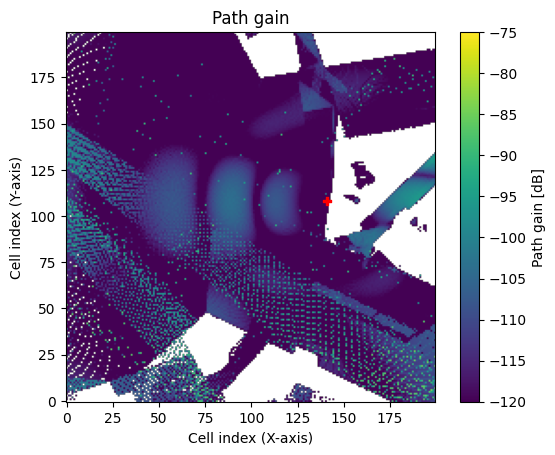

In [8]:
cm = scene.coverage_map(los=False, # Disable LOS for better visualization of the RIS field
                        num_samples=10**6,
                        cm_orientation=[0,0,0],
                        cm_center=[0,0,UE_Z],
                        cm_size=[200,200],
                        ris = False,
                        cm_cell_size=[1, 1])
no_ris = cm.show(vmin=-120, vmax=-75)


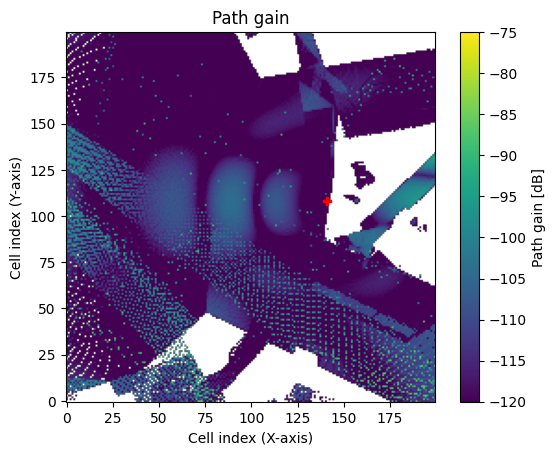

In [9]:
cm = scene.coverage_map(los=False, # Disable LOS for better visualization of the RIS field
                        num_samples=10**6,
                        cm_orientation=[0,0,0],
                        cm_center=[0,0,UE_Z],
                        cm_size=[200,200],
                        ris = True,
                        cm_cell_size=[1, 1])
yes_ris = cm.show(vmin=-120, vmax=-75)